# Training with VGG16 for handwritten Symbol Classification

---

IMPORTANT: We are assuming that the input data will have an unknown class and thatswhy we are making a model that gives 11 probabilities

In [1]:
def train(train_data, labels, learning_rate = 0.001, decay=1e-6, momentum=0.9, epochs = 15, batch_size = 20):
    
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('bmh')
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.models import Sequential
    import cv2
    from tensorflow import keras
    from keras import Model
    from keras.models import Sequential
    from keras.callbacks import ModelCheckpoint
    from keras.layers import Dense
    from keras.layers import Flatten
    from keras.applications.vgg16 import VGG16
    from keras.preprocessing import image
    from keras.applications.vgg16 import preprocess_input
    from keras.applications.vgg16 import decode_predictions
    from tensorflow.keras.optimizers import SGD
    from tensorflow.python.client import device_lib
    
    train_img = [] # holds the 3 channel image that is passed to model for training
    
    new_dimensions = (200,200) # reducing the size of imput images to make things easier and faster
    
    # VGG16 only takes images in 3 channels, so I need to convert npy data to 300X300 and then duplicate the channels
    for i in range(img_npy.shape[1]):
        temp_image = img_npy[:,i].reshape((300,300))
        temp_image = np.expand_dims(temp_image,-1)
        temp_image_3_channel = temp_image.repeat(3,axis=-1)
        resized_img = cv2.resize(src=temp_image_3_channel, dsize=new_dimensions, interpolation=cv2.INTER_LINEAR)
        train_img.append(resized_img)
        
    train_img = np.array(train_img)
    train_img = preprocess_input(train_img) # Preprocessing is necessary for VGG16
    
    # Splitting the test data and the validation
    X_train, X_valid, label_train, label_valid = train_test_split(train_img, label, test_size=0.3)
    
    # Normalizing the image data
    X_train = X_train/255
    X_valid = X_valid/255
    
    # Extracting features from the train dataset using the VGG16 pre-trained model
    model = VGG16(weights='imagenet', include_top=False, input_shape = (new_dimensions[0],new_dimensions[1],3), pooling='max')
    
    # Removing the last layer and adding 2 extra layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(1024, activation='relu')(flat1)
    output = Dense(11,activation='softmax')(class1)
    new_model = Model(inputs=model.inputs, outputs=output)
    
    new_model.summary()
    
    # Freezing the first 8 layers and training the rest of layers
    for layer in new_model.layers[:8]:

        layer.trainable = False
        
    
    checkpoint = ModelCheckpoint(filepath="./trained_VGG16_model.h5", ## creates a checkpoint so that it can be used to train the data from were
                                 monitor = "val_accuracy",            ## it stoped rather than just training it again from scratch also helps
                                 verbose = 1,                         ## save weights of the model.
                                 save_best_only = "True")
    
    optimizer_sdg = SGD(learning_rate=learning_rate, decay=decay, momentum=momentum, nesterov=True)
    
    new_model.compile(optimizer=optimizer_sdg, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    with tf.device('/gpu:0'):
        history = new_model.fit(X_train, label_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, label_valid), callbacks = [checkpoint])
        

    # plotting
    key_names = list(history.history.keys())
    colors = ['-r','--b','-og','-.k']

    plt.figure(figsize=(8,5))
    for i in range(len(key_names)):
        plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
        plt.xlabel("# of epochs")
    plt.legend(fontsize=15,ncol=2)
    plt.title('Learning Curves', size=15);
    
    return history

In [2]:
import numpy as np
img_npy = np.load('data_train_correct.npy')
label = np.load('labels_train_corrected.npy')

The corrected labels includes the label for "unknown" class, so total number of classes are 11 total classes

In [3]:
np.unique(label)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

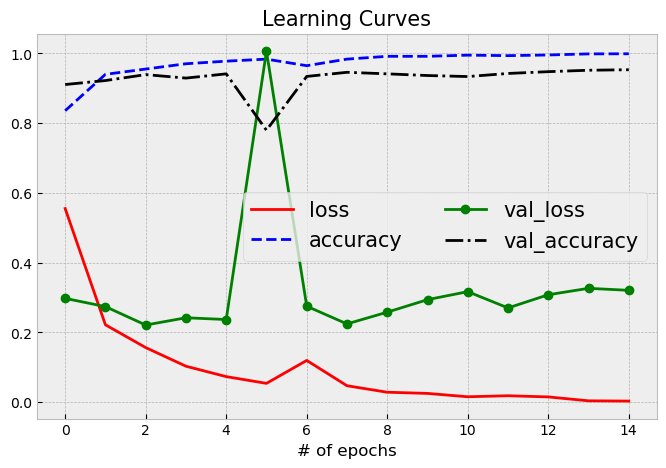

In [4]:
trained_history = train(img_npy, label)